# Data Gathering and merging

Since the used sensor system is sending the data to the cloud ThinkSpeak we have to implement a way, how to get the data from the internet and store it locally. In order to do so we first have to load the data, which is already stored on the computer. Then a pull request is made containing the last timestamp of the CSV data. This way it is not necessary to always download all data. Then the data has to brought in the right format, so that it then can be merged to the file on the computer.

In [1]:
import requests
import pandas as pd
import numpy as np

def get_data_from_CSV(file_path, column_names=['time', 'pH', 'EC', 'ORP', 'Temperature']):
    '''
    Function to get data from a CSV file
    '''

    data = pd.read_csv(file_path)
    data.columns = column_names
    if 'time' in data.columns:
        data['time'] = pd.to_datetime(data['time'])
        data.set_index('time', inplace=True)

    return data

def get_data_from_API(channel_id, api_key, timestamp):
    '''
    Function to get data from the ThingSpeak API
    '''

    get_url = f'https://api.thingspeak.com/channels/{channel_id}/feeds.csv?api_key={api_key}&start={timestamp}'
    response = requests.get(get_url)

    if response.status_code == 200:
        new_data = pd.read_csv(get_url)
        new_data = new_data[1:]     # remove first row (its the last entry from the last update)
    
    return new_data

def strip_data(data, column_names=['time', 'pH', 'EC', 'ORP', 'Temperature']):
    #TODO: + one hour to the time (Das fucked halt meine Listen mit den wichtigen Daten ab...)
    '''
    Function to strip the data from the API response. This is necessary because the API response contains a lot of unnecessary/empty information.
    '''

    data = data.drop(data.columns[[1]], axis=1)
    data = data.drop(data.columns[[5,6]], axis=1)      # remove unnecessary columns

    # Set the correct column names and convert the time column to datetime:
    data.columns = column_names
    data['time'] = data['time'].str.replace(' UTC', '')
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)

    # Remove zeros from value columns and replace them with the value of the previous row:
    for value_name in data.columns[1:]:
        prev_value = np.nan
        for index, value in data[value_name].items():
            if value == 0:
                data.at[index, value_name] = prev_value
            else:
                prev_value = value
    return data

def merge_data(new_data, old_data):
    # This function merges the new data with the old data
    data = pd.concat([old_data, new_data])
    data = data[~data.index.duplicated(keep='last')] # remove duplicates
    return data

def remove_outliers(data, threshold):
    #TODO: This function is not working properly yet
    '''
    This function removes outliers from the given data and returns the cleaned data
    The threshold defines the maximum difference between two values
    It's an simple algorithm that replaces outliers with the avarage of the previous and the next value
    '''

    avarage = data.iloc[:4].sum() / 4   # Calculate the avarage of the first 6 values
    
    for index, value in enumerate(data):
        if index <= 4 or index >= len(data) - 4:  # Skip first and last four value
            continue

        elif abs(value - avarage) > threshold:
            # First we have to calculate the avarage of the next 4 values
            # This helps to prevent that fast changes in the data are recognized as outliers, which especially important for EC
            next_avarage = data.iloc[index+1:index+5].sum() / 4 
            if abs(value - next_avarage) > threshold:
                # If the next value is also an outlier, we replace it with the avarage of the previous and the next value
                data.at[index] = round(avarage, 1)
                avarage = (data.iloc[index-1] + data.iloc[index+1]) / 2
            else:
                continue
        else:
            pass

        avarage = data.iloc[index-4:index].sum() / 4
    return data


### Use the functions above:

Since the channel is not getting updated anymore we will just load the saved data.

In [2]:
# Get the data from the CSV file:
complete_data = get_data_from_CSV('data.csv')

# Get the last timestamp from the old data:
#timestamp = old_data.iloc[-1].name
#timestamp = timestamp.strftime('%Y-%m-%dT%H:%M:%S')  
#
## ThinkSpeak data:
#channel_id = '2022980'
#api_key =  'JHMCEUJFTGCPYDZK'
#
## Get the new data and strip it:
#new_data = get_data_from_API(channel_id, api_key, timestamp)
#new_data = strip_data(new_data)
#
## Remove outliers from pH and ORP only:
#pH_threshold = 0.06
#ORP_threshold = 1
#
##old_data['pH'] = remove_outliers2(old_data['pH'], pH_threshold)         # Uncomment this line if you want to remove outliers from the old data
##old_data['ORP'] = remove_outliers2(old_data['ORP'], ORP_threshold)       # Uncomment this line if you want to remove outliers from the old data
#new_data['pH'] = remove_outliers(new_data['pH'], pH_threshold)
#new_data['ORP'] = remove_outliers(new_data['ORP'], ORP_threshold)
#
## Merge the new data with the old data and save it to a csv file:
#complete_data = merge_data(new_data, old_data)
#complete_data.to_csv('data.csv')

# Data Visualization

When dealing with sensor data, especially over time, the need for precise temporal insights becomes paramount. A well-crafted data visualization not only enhances our understanding of events but also enables the identification of patterns and anomalies that might be elusive in raw numerical formats.

The plot_data function is a robust data visualization function tailored to provide a dynamic exploration of the underlying sensor data. This function is designed to offer unparalleled flexibility, allowing users to specify start and end dates to focus on specific time frames. By doing so, we empower analysts to zoom in on critical periods, uncovering trends that might be hidden in the broader dataset.

In order to understand the underlying trends the "smoothing" function can be used. The purpose of this function is to mitigate the effects of noise in the data, thereby facilitating the identification of the underlying trend, particularly over extended periods. It is important to note that the original data points are still visible, but they are represented as gray dots behind the smoothed curve. This is intended to allow for the detection and analysis of noise and outliers, which may be critical in certain contexts.

## Example Usage

Consider the scenario where you need to find the start and time of an event you want to predict. The ability to zoom in and out in the data helps you set this point right where you need it. With this function, generating a customized plot for this specific time frame becomes a seamless process, providing a visual story of sensor data during those crucial moments. In essence, this self-crafted data visualization tool serves as a personalized lens, allowing to explore the sensor data. It is also tuned to save high resolution plots as PDF.

In [3]:
def smoothing(data, window_size):
    '''
    This function smooths the data by calculating the average of the values in a window around the current value
    '''
    
    smoothed_data = []
    for i in range(len(data)):
        if i < window_size:
            smoothed_data.append(sum(data[:i+window_size+1]) / (i+window_size+1))   # average of the first values
        elif i >= len(data) - window_size:
            smoothed_data.append(sum(data[i-window_size:]) / (len(data) - i + window_size))
        else:
            smoothed_data.append(sum(data[i-window_size:i+window_size+1]) / (2*window_size + 1))
    return smoothed_data

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 14             # general font size
plt.rcParams['axes.titlesize'] = 30        # axis title size
plt.rcParams['axes.labelsize'] = 30        # y axis label size
plt.rcParams['xtick.labelsize'] = 26       # x tick label size
plt.rcParams['ytick.labelsize'] = 26       # y tick label size
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['figure.titlesize'] = 14 
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['path.simplify'] = True
plt.rcParams['path.simplify_threshold'] = 0.9

def plot_data(features: list[str], data, start_date: str = None, end_date: str = None, window_size: int = 20, save: str = False, important_dates: list = [], date_format: str = '%d.%m.%y', colors = ['red', 'green', 'darkblue', 'orange']):
    '''
    This function plots the given data from start date to end date.

    Inputs:
    features: list of strings with the names of the features to plot
    start_date: string with the start date in the format 'YYYY-MM-DD HH:MM:SS'
    end_date: string with the end date in the format 'YYYY-MM-DD HH:MM:SS'
    data: pandas dataframe with the data. Format: ['time', 'pH', 'EC', 'ORP', 'Temperature']
    window_size: integer with the size of the window for smoothing the data
    save: string with the name of the file to save the plot
    important_dates: list of strings with the dates to mark in the plot
    '''

    # Define colors and labels of the plots:
    labels = ['pH', 'EC in $\mu$S/cm', 'ORP in mV', 'Temperature in °C']
    
    # Cut the data to the given start and end date, if given:
    if start_date is not None:
        data = data.loc[start_date:]
    if end_date is not None:
        data = data.loc[:end_date]
        
    number_of_plots = len(features)    # -1 because the time is not a feature
    subplot_number = 1

    plt.figure('Data Plot', figsize=(19, 14))       # was always 19, 9

    for feature in features:
        if feature == 'time':
            continue        # Skip the time feature

        plt.subplot(number_of_plots, 1, subplot_number)
        plt.plot(data.index, data[feature], '.C7', markeredgecolor='none', alpha = 0.3, rasterized=True)
        plt.plot(data.index, smoothing(data[feature], window_size), label=feature, color = colors[subplot_number-1])
        plt.ylabel(labels[subplot_number-1])
        #plt.legend(loc = "upper left")
        plt.xlim(data.index[0], data.index[-1])
        plt.grid(axis='y')

        ax = plt.gca()
        for date in important_dates:
            ax.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=1)
        
        '''Can be uncommented if necessary to mark the training and test data in the plot'''
        #plt.axvline(x=['2023-12-09 10:27:15'], color='black', linestyle='-', label='Split', linewidth=2.5)
        #plt.axvspan('2024-01-28 23:59:24', data[feature].index[-1], alpha=0.2, color='gray')
        #if subplot_number == 1:
        #    plt.text(data.index[11800], max(data[feature])-0.1, 'Trainings data', color='black', fontsize=28)
        #    plt.text(data.index[-4100], max(data[feature])-0.1, 'Test data', color='black', fontsize=28)

        subplot_number += 1

    xfmt = md.DateFormatter(date_format)       # Format of the x-axis labels
    ax.xaxis.set_major_formatter(xfmt)
    plt.xlabel("Date")
    plt.gcf().autofmt_xdate()   # Rotate the x-axis labels for better readability
    plt.tight_layout(pad=0.8)

    # Save plot:
    if save:
        current_directory = os.getcwd()
        #pic_directory = os.path.join(current_directory, 'Bilder')
        filename = os.path.join(current_directory, f"{save}")
        plt.savefig(filename, dpi=150)

    plt.show()

In [6]:
# Feedings:
feeding_dates_complete = ['2023-12-05 08:32:30', '2023-12-07 07:45:47', '2023-12-09 08:05:46', '2023-12-09 09:30:03', '2023-12-13 12:48:30', '2023-12-16 09:09:08', '2023-12-19 11:24:27', '2023-12-25 08:22:57', '2023-12-29 10:33:13', '2023-12-31 11:44:29', '2024-01-03 13:47:15', '2024-01-10 13:39:25', '2024-01-16 13:51:23', '2024-01-19 15:35:29', '2024-01-23 11:23:24', '2024-01-23 13:11:40', '2024-01-26 14:37:10']
feeding_amounts = [6, 6.5, 6, 6, 9.8, 6.3, 7.3, 7.6, 7, 10, 7]  # in g

# Water refills:
refill_dates = ['2023-12-02 17:12:34', '2023-12-25 07:49:51', '2024-01-11 11:55:04']
water_refill_amounts = [4, 4, 10]

# Nutrient boosts:
boost_dates = ['2023-12-08 13:37:53', '2024-01-24 07:30:45']
boost_amounts = [1.56]

# Other:
other_dates = ['2023-12-20 15:17:04', '2024-01-05 10:06:57']        # Reinigung Syphon, Pumpenausfall

test_dates = ['2024-01-29 10:52:06', '2024-02-02 11:28:51', '2024-02-04 10:45:43', '2024-02-06 11:29:56', '2024-02-08 07:19:32', '2024-02-11 08:37:17']   # Boost + Refill, Feeding, little Boost, Feeding, Refill, Feeding

normal_dates = ['2023-12-22 13:35:38', '2023-12-22 04:37:10', '2024-01-25 06:25:46', '2023-12-12 04:02:23', '2024-01-02 07:03:35', '2024-01-08 05:29:57', '2024-01-15 05:59:33', '2024-01-09 08:04:28', '2024-01-09 15:02:36', '2023-12-03 04:29:58', '2023-12-03 17:02:36', '2023-12-04 03:07:55', '2023-12-05 01:10:00', '2023-12-07 00:23:12', '2023-12-08 03:02:43', '2023-12-11 12:01:49', '2023-12-12 08:57:32', '2023-12-21 04:02:40', '2023-12-22 06:55:31', '2023-12-23 07:29:34', '2023-12-14 06:58:51', '2023-12-14 14:15:23', '2023-12-14 19:04:23', '2023-12-15 15:20:48', '2023-12-15 05:03:33', '2023-12-16 05:59:34', '2023-12-17 12:59:05', '2023-12-17 05:54:51', '2023-12-18 20:58:04', '2023-12-18 18:00:39', '2023-12-18 06:01:47', '2023-12-19 04:01:57', '2023-12-20 02:44:44', '2023-12-21 08:54:33', '2023-12-21 21:08:58', '2023-12-22 18:48:29', '2023-12-22 12:08:24', '2023-12-23 20:22:55', '2023-12-23 13:24:38', '2023-12-30 08:39:53', '2023-12-30 15:32:04', '2024-01-01 17:07:17', '2024-01-02 18:02:24', '2024-01-24 11:31:22', '2023-12-14 13:24:12', '2024-01-29 14:34:42', '2024-01-08 17:32:01', '2024-02-02 12:53:04', '2024-01-08 08:51:28', '2024-01-08 07:42:18', '2024-01-31 21:07:31','2024-02-01 19:56:19', '2024-02-02 11:22:50']  # Last dates is getting interpretated as Feeding but no feeding happened 

# removed from normal: '2024-01-31 05:23:00',

important_dates = feeding_dates_complete + refill_dates + boost_dates + other_dates + test_dates

### Use the function:

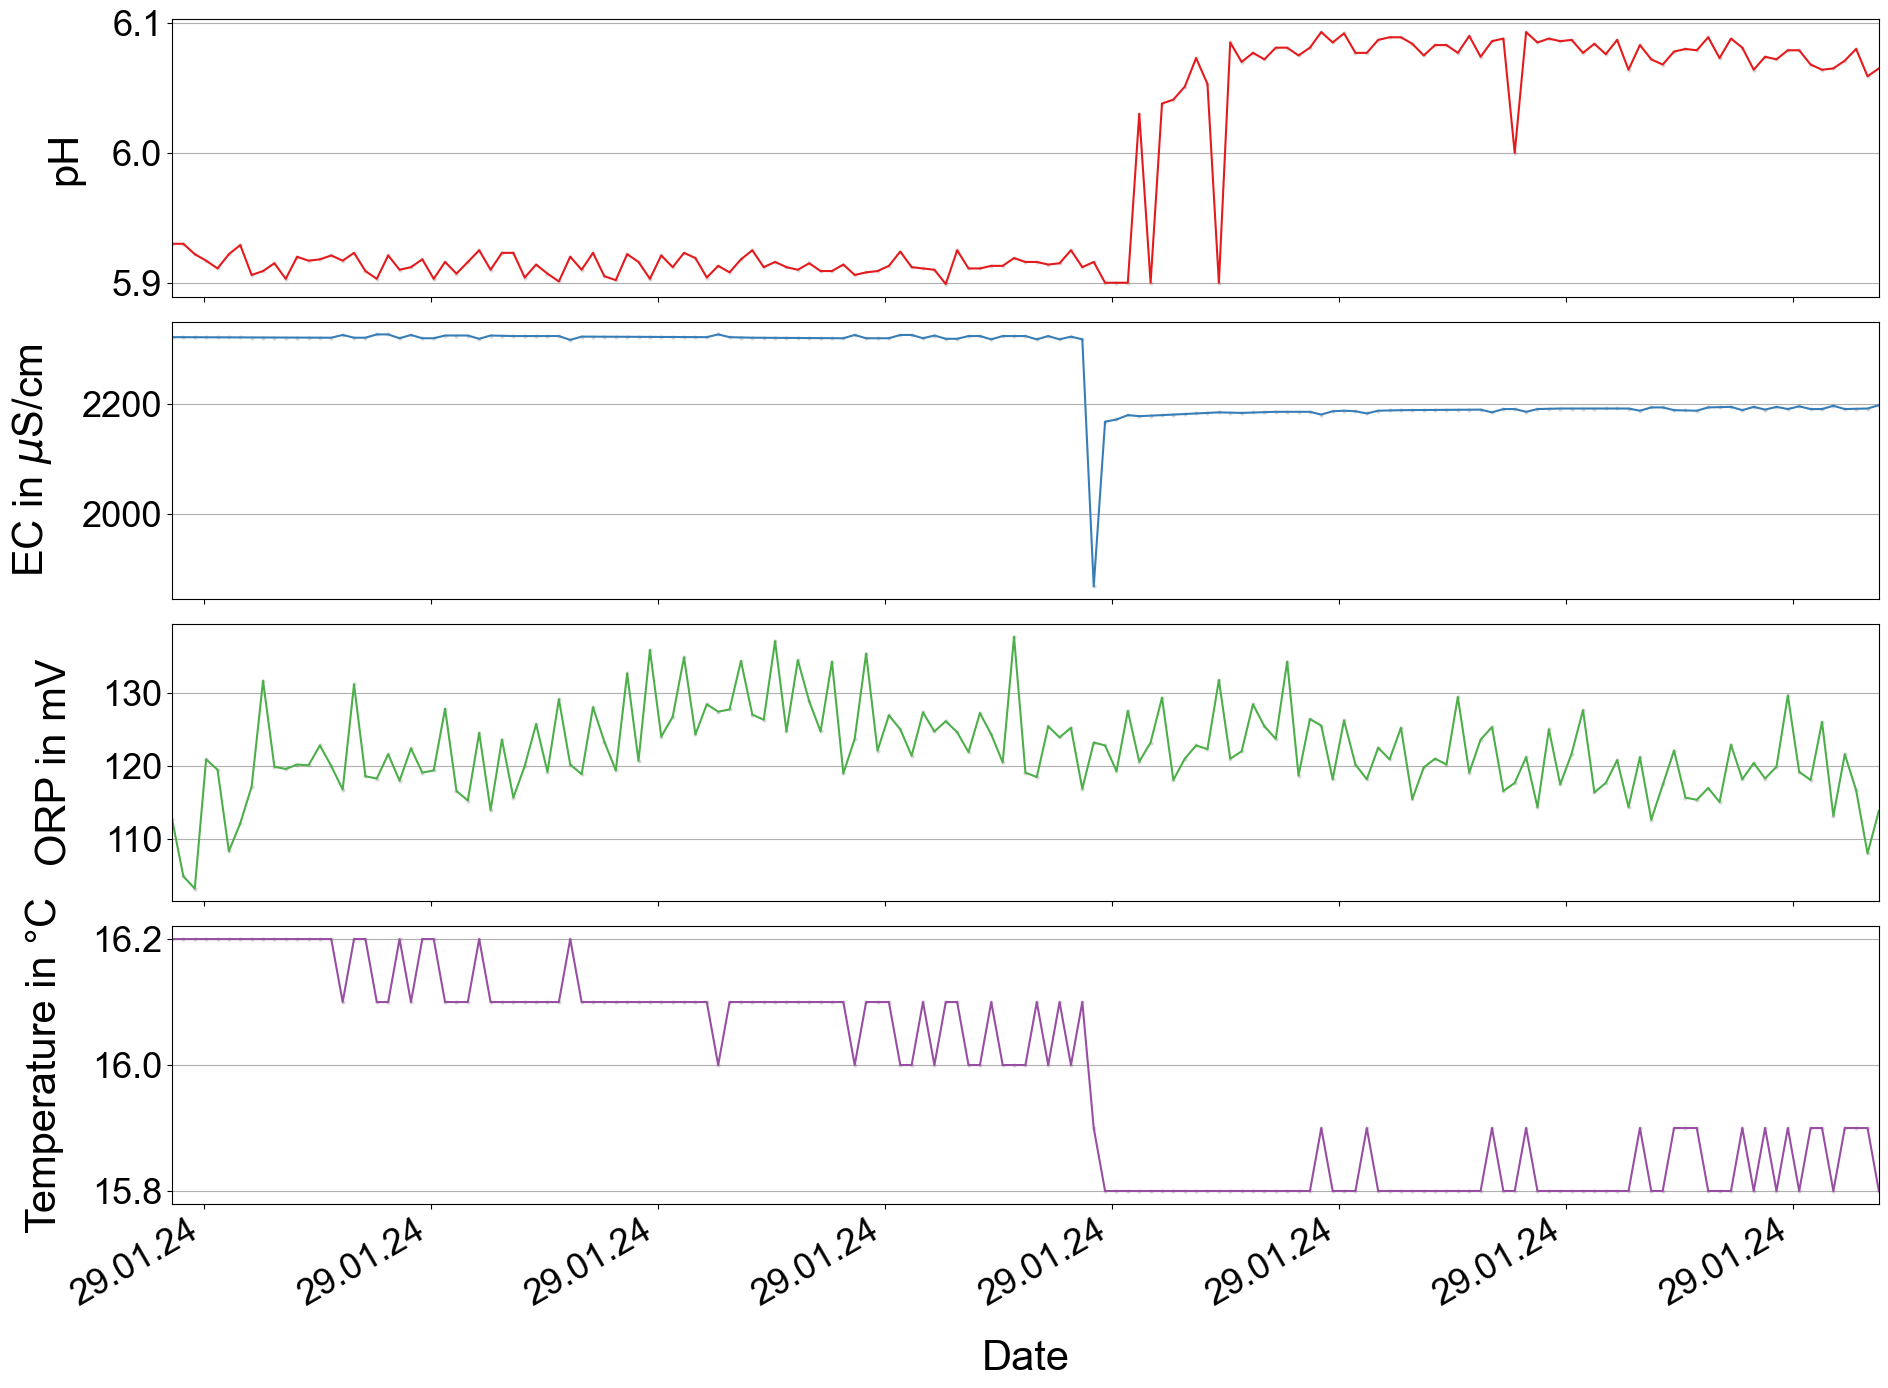

In [19]:
import seaborn as sns
colors = sns.color_palette("Set1", n_colors=4)      # Creates a list of colors for the plot

# Settings
features = ['pH', 'EC', 'ORP', 'Temperature']
start_date = '2024-01-29 06:51:28'
end_date = '2024-01-29 14:22:40'
date_fomat = '%d.%m.%y'

# Plot the data:
plot_data(features, complete_data, important_dates=important_dates start_date=start_date, end_date=end_date, window_size=0, date_format=date_fomat, colors=colors, save='FullPlot.pdf') 

# Data Preprocessing

After labeling every event, a set can be created to train the models. For each event, the sensor data in the vicinity of the event is inserted into a new data frame. The moment of the event is placed in the middle of each window. A window width of 60 values was chosen, which is a compromise between fast detection of the events and sufficient change for events that slowly change the water values.
*
For the models to work effectively, it is recommended to place the moment of feeding on the left side of the window and add an extra window on the right side of the first one. This is because the water parameter changes at a slower rate during feeding compared to other events. By doing this, it is possible to ensure that the parameters change enough, and the models don't face issues while mixing feeding events with windows that do not have any specific event.

In [13]:
def create_train_set(data, feeding_dates=[], refill_dates=[], boost_dates=[], other_dates=[], normal_dates=[], TIME_WINDOW=60, RATIO=0.1):
    '''
    This function creates the training/test set for the given data and the given events.
    It gives each date inserted a unique ID and returns the ID dictionary.
    Maybe the end of the feedings will have to be added, in order to detect those parts as well!
    '''
    
    train_set = pd.DataFrame(columns=['time', 'ID', 'pH', 'EC', 'ORP', 'Temperature'])
    train_set.set_index('time', inplace=True)

    ID = 0
    ID_DICT = {'Feedings': [], 'Refills': [], 'Boosts': [], 'Cleaning': [], 'Normal': []}    # Save the ID of the measurement and the corresponding date

    # Add feeding windows to the train set:
    for date in feeding_dates:
        current_index = data.index.get_loc(date)        # Get the index of the date in the data
        feeding = data.iloc[current_index - int(TIME_WINDOW * RATIO) : current_index + int(TIME_WINDOW * (1 - RATIO))].copy()    # Left window
        feeding.loc[:, 'ID'] = ID
        train_set = pd.concat([train_set, feeding], ignore_index=True, axis=0)
        ID_DICT['Feedings'] += [ID]
        ID += 1

        feeding1 = data.iloc[current_index + int(TIME_WINDOW * (1 - RATIO)) : current_index + int(TIME_WINDOW * (1 - RATIO)) + TIME_WINDOW].copy()    # Right window
        feeding1.loc[:, 'ID'] = ID
        train_set = pd.concat([train_set, feeding1], ignore_index=True, axis=0)
        ID_DICT['Feedings'] += [ID]
        ID += 1
        
    # Add refill windows to the train set:
    for date in refill_dates:
        current_index = data.index.get_loc(date)

        refill = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()    # Event in the middle of the window
        refill['ID'] = ID
        train_set = pd.concat([train_set, refill], ignore_index=True, axis=0)
        ID_DICT['Refills'] += [ID]
        ID += 1

    # Add boost windows to the train set:
    for date in boost_dates:
        current_index = data.index.get_loc(date)
        boost = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()    # Event in the middle of the window
        boost['ID'] = ID
        train_set = pd.concat([train_set, boost], ignore_index=True, axis=0)
        ID_DICT['Boosts'] += [ID]
        ID += 1
    
    # Add other windows to the train set:
    for date in other_dates:
        current_index = data.index.get_loc(date)
        other = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()   # Event in the middle of the window
        other['ID'] = ID
        train_set = pd.concat([train_set, other], ignore_index=True, axis=0)
        ID_DICT['Cleaning'] += [ID]
        ID += 1

    # Add normal windows to the train set:
    for date in normal_dates:
        current_index = data.index.get_loc(date)
        normal = data.iloc[current_index - int(TIME_WINDOW / 2)  : current_index + int(TIME_WINDOW / 2)].copy()
        normal['ID'] = ID
        train_set = pd.concat([train_set, normal], ignore_index=True, axis=0)
        ID_DICT['Normal'] += [ID]
        ID += 1
        
    return train_set, ID_DICT

In [14]:
TIME_WINDOW = 60     
RATIO = 0.2

train_set, ID_DICT = create_train_set(complete_data, feeding_dates=feeding_dates_complete, refill_dates=refill_dates, boost_dates=boost_dates, other_dates=other_dates, normal_dates=normal_dates, TIME_WINDOW=TIME_WINDOW, RATIO=RATIO)

print(ID_DICT)
print(train_set.head())
print(train_set.tail())
#train_set.to_csv('Versuch_3/Versuch_03_train_set.csv')

{'Feedings': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'Refills': [34, 35, 36], 'Boosts': [37, 38], 'Cleaning': [39, 40], 'Normal': [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]}
  ID     pH      EC    ORP  Temperature
0  0  6.671  1827.0  129.1         17.5
1  0  6.650  1827.0  128.3         17.5
2  0  6.666  1827.0  129.3         17.5
3  0  6.649  1827.0  137.2         17.5
4  0  6.652  1827.0  129.8         17.5
      ID     pH      EC    ORP  Temperature
5635  93  6.031  2247.0   92.1         17.9
5636  93  6.024  2247.0   91.8         17.9
5637  93  6.029  2248.0  114.7         17.9
5638  93  6.023  2247.0   94.5         17.9
5639  93  6.019  2247.0   93.8         17.9


C:\Users\Manu\AppData\Local\Temp\ipykernel_7828\1873919768.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_set = pd.concat([train_set, feeding], ignore_index=True, axis=0)


# Output Vector

Now we need to make the output vector for the training set. This has the advantage of assigning a unique event to each ID. This vector has the length of the number of test sets from the previous function.

In [16]:
def make_y(ID_DICT, event_mapping_dict):
    '''
    This function creates the y vector for the training the model.
    '''

    y = pd.Series([])
    for event, id in ID_DICT.items():
        length = len(id)
        number = event_mapping_dict[event]
        y = pd.concat([y, pd.Series([number] * length)], ignore_index=True, axis=0) 

    return y

In [17]:
event_mapping_dict = {'Normal': 0, 'Feedings': 1, 'Refills': 2, 'Boosts': 3, 'Cleaning': 4}       # Gives each event a unique number
reverse_mapping_dict = {value: key for key, value in event_mapping_dict.items()}                  # Is needed since the model will return the numbers and not the names of the events

y = make_y(ID_DICT, event_mapping_dict)

print(y.shape, train_set.shape)
print(y.tail())

(94,) (5640, 5)
0    1
1    1
2    1
3    1
4    1
dtype: int64


C:\Users\Manu\AppData\Local\Temp\ipykernel_7828\1668166392.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, pd.Series([number] * length)], ignore_index=True, axis=0)


### Feature Extraction

Because time series are often quite confusing to machine learning algorithms and have various defects, such as noise or outliers, it can often be the case that models have problems classifying them correctly. Another issue, especially with very long and multivariate time series, is that they can have a very high dimensionality, which can severely affect the classification performance. To increase the accuracy of classification, feature extraction is an important part of developing a model for time series classification. Since the extraction of these features plays such an important role in the classification of time series, it must be given a particularly important role. Some of these properties to be extracted, such as mean, minimum and maximum values, or slope, are quite obvious. Others, such as entropy or Discrete Fourier Transform Coefficients, are less obvious. However, these can also contribute greatly to the accuracy of the selected model.

Due to the large number of features that can be extracted from time series, this can be a very time-consuming step when creating a model. To simplify this step, various libraries that specialize in exactly this problem can be used. The most common libraries in Python are *'tsfresh'*, *'TSFEL'* and *'Kats'*. The *'tsfresh'* library is one of the most comprehensive and will be used in this thesis. It is able to compute 1558 features from time series data. Another major advantage of *'tsfresh'* is that it is able to find the most important features for classification itself, which removes unnecessary values for training the model. By further reducing the dimensionality of the input variables, even more accurate models can be developed. These features can then be used to train machine learning models.

In [18]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

X = extract_features(train_set, column_id="ID", impute_function=impute, n_jobs=1)
print(f'X_shape: {X.shape}, y_shape: {y.shape}')

Since the 

In [19]:
# Extract features:
def get_relevant_features(input_data, target):
    '''
    This function filters the relevant features from the given data.
    '''

    relevant_features_set = set()   # using a set to prevent duplicates

    for class_label in target.unique():
        binary_target = target == class_label
        filtered_data = select_features(input_data, binary_target)
        print("Number of relevant features for class {}: {}/{}".format(class_label, filtered_data.shape, input_data.shape))
        relevant_features_set = relevant_features_set.union(set(filtered_data.columns))

    print(f'Total of {len(relevant_features_set)} relevant features have been identified for class {class_label}.')
    return relevant_features_set

In [38]:
relevant_features = get_relevant_features(X, y)

X_train_filtered = X[list(relevant_features)]

'''Save relevant features to csv file:
Which is really important because the models will be trained on the filtered data
and then can only be used with features that are in the same order.'''

X_train_filtered.to_csv('X_train_filtered.csv')

Number of relevant features for class 1: 210/3132
Number of relevant features for class 2: 72/3132
Number of relevant features for class 3: 0/3132
Number of relevant features for class 4: 0/3132
Number of relevant features for class 0: 205/3132
It have been 302 relevant features found.


In [20]:
import pickle

def save_model(model, filename):
    '''
    This function saves the model to a pickle file.
    '''

    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    '''
    This function loads the model from a pickle file.
    '''

    model = pickle.load(open(filename, 'rb'))
    return model

## GridSearch:

In order to create the most accurate models possible, some settings are defined in advance. These settings are known as hyperparameters. The correct choice of these parameters allows the creation of highly specialized models. However, the number of adjustable hyperparameters varies from model to model. Furthermore, the selection of the correct hyperparameters is not very clear. Trying to find the best parameters is called tuning. Applying the so-called grid search is a widely used technique to tune these hyperparameters. This involves building a dictionary of different hyperparameters and defining a model for each set of parameters. Then, the models are compared, and the best-performing model can be determined. This step is crucial when building a model and should not be omitted, even though the computation can take a long time depending on the model

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.tree import DecisionTreeClassifier

# Define the models:
decision_tree_calssifier = DecisionTreeClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()

# Define the parameters for the grid search:
# Decision Tree:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Gradient Boosting:
param_grid_gb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.02],
    'max_depth': [4, 8],
    'min_samples_leaf': [3, 9],
    'max_features': [1.0, 0.1]
}

# KNN:
param_grid_knn = {
    'n_neighbors': [1, 2, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

def grid_search(model, param_grid, X_train, y_train, n_splits=2, shuffle=True, random_state=42, n_jobs=-1):
    '''
    This function performs a grid search for the given model and the given parameters.
    '''

    cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(type(model))
    print("Best parameters for the Classifier:", best_params)
    print("Best score for the Classifier:", best_score)


# Do the grid search (uncomment for the model you want to use):
#grid_search(decision_tree_calssifier, param_grid_dt, X_train_filtered, y)
#grid_search(gradient_boosting_classifier, param_grid_gb, X_train_filtered, y)
#grid_search(knn_classifier, param_grid_knn, X_train_filtered, y)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best parameters for the Classifier: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best score for the Classifier: 0.6276595744680851


## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

decision_tree_classifier2 = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=6, min_samples_split=15)
decision_tree_classifier2.fit(X_train_filtered, y)

# Save the model to a pickle file:
#save_model(decision_tree_calssifier, 'Versuch_3/Versuch_03_decision_tree_classifier.pkl')

## GradientBoostingClassifier

In [38]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boosting_classifier2 = GradientBoostingClassifier(learning_rate=0.02, max_depth=4, min_samples_leaf=9, max_features=0.1, n_estimators=300)
gradient_boosting_classifier2.fit(X_train_filtered, y)

# Save the model to a pickle file:
#save_model(gradient_boosting_classifier, 'Versuch_3/Versuch_03_Gradient_Boosting.pkl')

GradientBoostingClassifier(learning_rate=0.02, max_depth=4, max_features=0.1,
                           min_samples_leaf=9, n_estimators=300)

## k-Nearest Neighbor


In [40]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors_classifier2 = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', metric='manhattan', p=1)
k_neighbors_classifier2.fit(X_train_filtered, y)

# Save the model to a pickle file:
#save_model(k_neighbors_classifier2, 'Versuch_3/Versuch_03_k_NN_classifier.pkl')

KNeighborsClassifier(metric='manhattan', n_neighbors=2, p=1)

# Use the model

In order to use the generated models, the analyzed data must be put back into the same format ['ID', 'pH', 'EC', 'ORP', 'Temperature']. The function *'make_test_set'* is used for this. This takes the complete data, a start- and end date, and, if necessary, the target column names as input. First, the inserted data is limited to the given period using the start- and end date. A new DataFrame is created with the column names and the data is inserted accordingly. As the index of the complete data, which are in the form of timestamps, is also transferred in this way, the index of the generated DataFrame must be reset.

One of the main components of being able to use a model with *'tsfresh'* is the sorting of the extracted properties. This is necessary because the models can only cope with the same order of data that was used for training. This is why the *'sort_X'* function was implemented. As input for the function serves the matrix X created by *'tsfresh'* and the columns of the DataFrame *'X_sorted'* that was used for training as input. The column names of *'X_sorted'* are now used to create a new DataFrame. Then the columns of the X vector are iterated over and if a column name is also present in *'X_sorted'*, the value of X is added to the sorted DataFrame.

In [22]:
def make_test_set(data, start_date, end_date, test_set_columns=['ID', 'pH', 'EC', 'ORP', 'Temperature'], ID=0):
    '''
    This function creates a test set for the given data and the given time window.
    It returns the test set.
    '''
    
    test_data = data.loc[start_date:end_date]
    test_set = pd.DataFrame(columns=test_set_columns)
    test_set['pH'] = test_data['pH']
    test_set['EC'] = test_data['EC']
    test_set['ORP'] = test_data['ORP']
    test_set['Temperature'] = test_data['Temperature']
    test_set['ID'] = ID
    test_set = test_set.reset_index(drop=True)    # make sure the index is set right

    return test_set

def sort_X(X, columns: list[str]):
    '''
    This function sorts the X Dataframe in the same way as the X_train_used.csv
    This is necessary because the order of the features is important for the model
    Otherwise it can not be used for classification.
    '''

    new_data_frame = pd.DataFrame(columns=columns)

    # drop first  coloumn of new dataframe
    new_data_frame = new_data_frame.drop(columns=['Unnamed: 0'])

    # Add the Values from X to the dataframe
    for name in X.columns:
        if name in columns:
            new_data_frame[name] = X[name]

    return new_data_frame

In [23]:
# Make for each event one test set:
TEST_SET1 = make_test_set(complete_data, start_date='2024-01-29 09:21:52', end_date='2024-01-29 12:19:20', ID=0)  # Boost + Refill
TEST_SET2 = make_test_set(complete_data, start_date='2024-02-04 14:10:15', end_date='2024-02-04 17:07:45', ID=1)  # Normal
TEST_SET3 = make_test_set(complete_data, start_date='2024-02-02 10:28:41', end_date='2024-02-02 13:26:09', ID=2)  # Feeding1
TEST_SET4 = make_test_set(complete_data, start_date='2024-02-06 10:29:46', end_date='2024-02-06 13:27:15', ID=3)  # Feeding2
TEST_SET5 = make_test_set(complete_data, start_date='2024-02-06 01:46:20', end_date='2024-02-06 04:43:49', ID=4)  # Normal
TEST_SET6 = make_test_set(complete_data, start_date='2024-02-01 21:29:34', end_date='2024-02-02 00:27:04', ID=6)  # Normal
TEST_SET7= make_test_set(complete_data, start_date='2024-02-05 00:11:56', end_date='2024-02-05 03:09:25', ID=7)  # Normal

# Concatenate the test sets:
TEST_SET = pd.concat([TEST_SET1, TEST_SET2, TEST_SET3, TEST_SET4, TEST_SET5, TEST_SET6, TEST_SET7], ignore_index=True, axis=0)

# Extract the features from the test set and filter them according to the relevant features:
X_test = extract_features(TEST_SET, column_id="ID", impute_function=impute, n_jobs=1)
X_test_filtered_columns = pd.read_csv('X_train_filtered_Versuch_04.csv').columns
X_test_filtered = sort_X(X_test, X_test_filtered_columns)        # hier muss dann noch die Reihenfolge angepasst werden

# Create the y_test vector:
y_test = pd.Series([2, 0, 1, 1, 0, 0, 0])

print(TEST_SET.shape)
print(TEST_SET.head(5))

Feature Extraction:   0%|          | 0/28 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


(420, 5)
   ID     pH      EC    ORP  Temperature
0   0  5.918  2321.0  134.3         16.1
1   0  5.925  2321.0  127.0         16.1
2   0  5.912  2321.0  126.3         16.1
3   0  5.916  2321.0  137.0         16.1
4   0  5.912  2321.0  124.7         16.1


In [40]:
print(classification_report(y_test, decision_tree_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [43]:
print(classification_report(y_test, k_neighbors_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1

    accuracy                           0.57         7
   macro avg       0.53      0.58      0.56         7
weighted avg       0.49      0.57      0.52         7



In [42]:
print(classification_report(y_test, gradient_boosting_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



# Testing the models:

 The *'simulate'* function was implemented to examine the model's performance over an extended period. The function takes the complete data, a start and end date, the DataFrame used for training, the model, the dictionary for event mapping, the models and a window size as input. This function then makes a classification for each window in the given period and prints its predicted event. The tested period is from 06.02.2024 to 08.02.2024.

In [44]:
def simulate(data, start_date, end_date, reverse_mapping_dict, classifiers, filter_coloums, WINDOW_SIZE=60):
    '''
    This function simulates the use of the model. It takes the data, a starting and end point and testes the model for each time step.
    It returns the predicted event and the corresponding probability.
    '''

    simulate_data = data.loc[start_date:end_date]
    
    # Create a DataFrame to save the results
    results = pd.DataFrame(columns=['time'])
    for classifier in classifiers:
        results[classifier.__class__.__name__] = None       # Add a column for each classifier
    
    # Now extract the features from the data:
    for i in range(len(simulate_data)-WINDOW_SIZE):
        TEST_SET = make_test_set(data, start_date=simulate_data.index[i], end_date=simulate_data.index[i+WINDOW_SIZE])
        X_test = extract_features(TEST_SET, column_id="ID", impute_function=impute, n_jobs=1)
        X_test_filtered = sort_X(X_test, filter_coloums)        # Filter for relevant features
        new_row = {'time': simulate_data.index[i+WINDOW_SIZE]}
        
        # Make the prediction for each classifier:
        for classifier in classifiers:
            out = classifier.predict(X_test_filtered)
            predicted_event = reverse_mapping_dict.get(out[0], 'Unbekannt') 
            new_row[classifier.__class__.__name__] = predicted_event        # Add predicted event to the new row
            print(f'Predicted event from {classifier.__class__.__name__} at {simulate_data.index[i+WINDOW_SIZE]}: {predicted_event}')

        results.loc[len(results)] = new_row
        new_row = {}

    # Set time as index
    results.set_index('time', inplace=True)
    return results

In [24]:
import joblib

'''If needed we can also load old models from the pickle files'''
#decision_tree_classifier = joblib.load('Versuch_3/Versuch_03_decision_tree_classifier.pkl')
#gradient_boosting_classifier = joblib.load('Versuch_3/Versuch_03_Gradient_Boosting.pkl')
#k_neighbors_classifier = joblib.load('Versuch_3/Versuch_03_k_NN_classifier.pkl')

In [ ]:
# Never seen events, always 100 predictions:
# The start- and end date can be copied in the function call below.

# feeding1 = ['2024-02-02 11:28:51']
# start_date='2024-02-02 08:01:16', end_date='2024-02-02 15:59:34',

# feeding2 = ['2024-02-06 11:29:56']
# start_date='2024-02-06 07:56:21', end_date='2024-02-06 14:36:27',

# Refills/Boost = ['2024-01-29 10:52:06']
# start_date='2024-01-29 07:39:35', end_date='2024-01-29 15:37:51',

# MiniBoost = ['2024-02-04 10:45:43']
# start_date='2024-02-04 07:15:09', end_date='2024-02-04 15:13:26',

# Normal:
# start_date='2024-02-04 13:10:05', end_date='2024-02-04 21:08:26',

# Little Boost:
# start_date='2024-02-04 07:39:13', end_date='2024-02-04 15:37:30'

# Refill = ['2024-02-08 07:19:32']
# start_date='2024-02-08 03:48:58', end_date='2024-02-08 12:17:28'

# LongTerm:
# start_date='2024-02-06 06:29:06', end_date='2024-02-08 12:17:28',

# LongLongTerm
# start_date='2024-01-29 00:02:24', end_date='2024-02-08 12:17:28'

In [28]:
import pandas as pd
# Get the used X_train_filtered, so we can sort the extracted features in the same way
X_train_used = pd.read_csv('X_train_filtered.csv')
filter_coloums = X_train_used.columns

results = simulate(complete_data, start_date='2024-02-08 03:48:58', end_date='2024-02-08 12:17:28', classifiers=[k_neighbors_classifier2], reverse_mapping_dict=reverse_mapping_dict, filter_coloums=filter_coloums, WINDOW_SIZE=60)

# Save the results to a csv file:
#results.to_csv('Versuch_3/Versuch_03_Complete_LongLongTerm.csv')

## Vizualize Results

Now we can create a plot out of the results. The event_mapping_dict can be used in order to 'translate' the strings into a number. This shall help see how often the models fluctuate between the events.

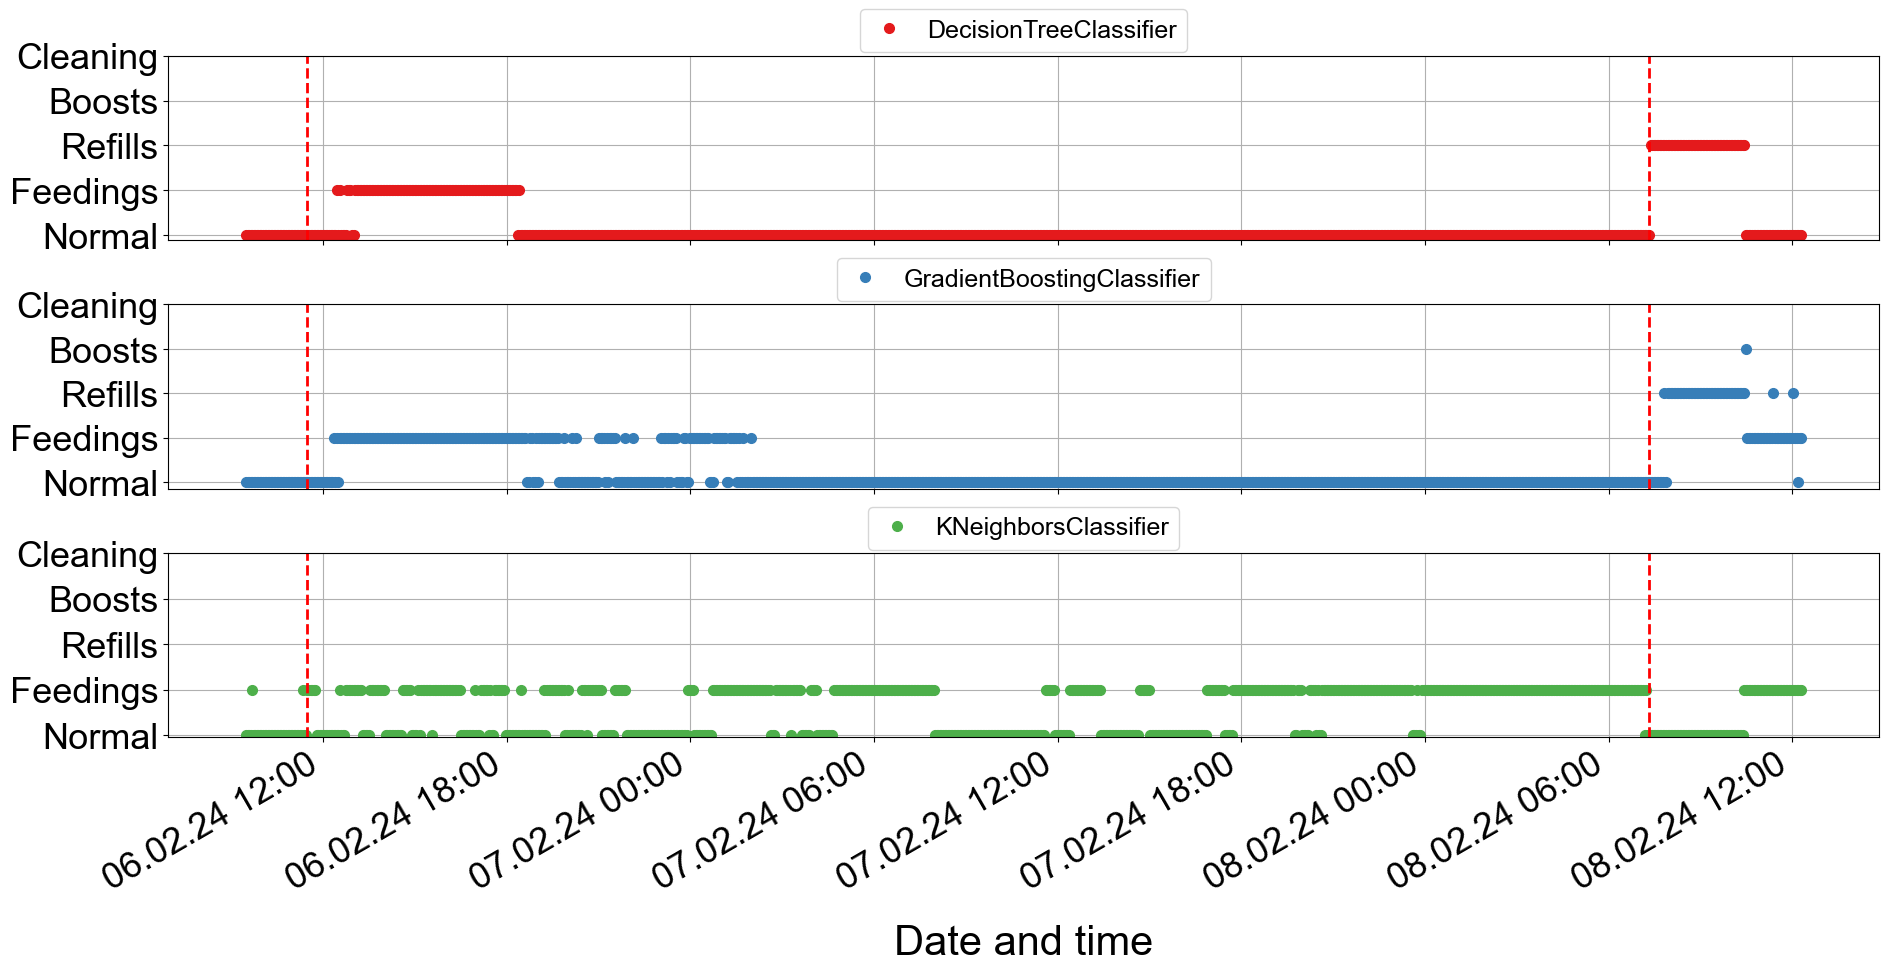

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

colors = sns.color_palette("Set1", n_colors=3)

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 14             # general font size
plt.rcParams['axes.titlesize'] = 30        # axis title size
plt.rcParams['axes.labelsize'] = 30        # y axis label size
plt.rcParams['xtick.labelsize'] = 26       # x tick label size
plt.rcParams['ytick.labelsize'] = 26       # y tick label size
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['figure.titlesize'] = 14 
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['path.simplify'] = True
plt.rcParams['path.simplify_threshold'] = 0.9

# Read results from CSV

feeding_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Feeding.csv', index_col=0, parse_dates=True)
feeding_results.index = pd.to_datetime(feeding_results.index)

normal_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Normal.csv', index_col=0, parse_dates=True)
normal_results.index = pd.to_datetime(normal_results.index)

refill_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Refill.csv', index_col=0, parse_dates=True)
refill_results.index = pd.to_datetime(refill_results.index)

long_term = pd.read_csv('Versuch_3/Versuch_03_Complete_LongTerm.csv', index_col=0, parse_dates=True)
long_term.index = pd.to_datetime(long_term.index)

# Just in case redefine the event mapping dict
event_mapping_dict = {'Normal': 0, 'Feedings': 1, 'Refills': 2, 'Boosts': 3, 'Cleaning': 4} 

# Replace strings with numbers:
feeding_results_numeric = feeding_results.apply(lambda col: col.map(event_mapping_dict))
normal_results_numeric = normal_results.apply(lambda col: col.map(event_mapping_dict))
refill_results_numeric = refill_results.apply(lambda col: col.map(event_mapping_dict))
long_term_numeric = long_term.apply(lambda col: col.map(event_mapping_dict))

# Plot the results:
def plot_results(results, mapping_dict=event_mapping_dict, colors=['red', 'green', 'blue'], events=[]):
    subplot_number = 1
    number_of_subplots = len(results.columns)
    plt.figure('Results', figsize=(19, 10))

    for model in results.columns:
        plt.subplot(number_of_subplots, 1, subplot_number)
        plt.plot(results.index, results[model], label=model, marker='o', markersize=7, linestyle='', color=colors[subplot_number-1], rasterized=True)
        
        for event in events:
            plt.axvline(x=pd.to_datetime(event), color='red', linestyle='--', linewidth=2)

        ax = plt.gca()
        xfmt = md.DateFormatter('%d.%m.%y %H:%M')       # Format of the x-axis labels
        ax.xaxis.set_major_formatter(xfmt)
        plt.xlabel("Date and time")
        plt.gcf().autofmt_xdate()   # Rotate the x-axis labels for better readability
        plt.tight_layout(pad=0.8)
        #plt.ylabel('Event')
        plt.yticks(list(mapping_dict.values()), list(mapping_dict.keys()))
        plt.grid()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.32))
        subplot_number += 1

    plt.subplots_adjust(hspace=0.35)
    plt.savefig('Versuch_3/Versuch_03_Complete_LongTerm.pdf')
    plt.show()

#plot_results(boost_and_refill_numeric, colors=colors, events=['29.01.2024 10:52'])
#plot_results(feeding_results_numeric, colors=colors, events=['02.02.2024 11:28'])
#plot_results(refill_results_numeric, colors=colors, events=['2024-02-08 07:19:32'])
#plot_results(miniboost_results_numeric, colors=colors, events=['2024-02-04 10:45:43'])
#plot_results(normal_results_numeric, colors=colors)
plot_results(long_term_numeric, colors=colors, events=test_dates[-3:-1])       #For only LongTerm: ['2024-02-06 11:29:56', '2024-02-08 07:19:32']